In [1]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import re
import string
import json
import or_gym
from or_gym.algos.knapsack.math_prog import *
from or_gym.algos.knapsack.heuristics import *
from or_gym.algos.math_prog_utils import *
from or_gym.algos.rl_utils import *
from or_gym.benchmarks.knapsack.ukp_benchmark import *
from or_gym.benchmarks.knapsack.bkp_benchmark import *
from or_gym.benchmarks.knapsack.okp_benchmark import *
import copy
import ray
# from ray.rllib import agents

%matplotlib inline
plt.style.use('cmu_paper')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# ray.init(ignore_reinit_error=True)

In [8]:
def extract_plot_stats(path, window=100):
    ep_stats = ['hist_stats/episode_reward']
    train_data = pd.read_csv(path + '/progress.csv')
    for i in ep_stats:
        vals = None
        ep_vals = train_data[i].values
        for j in ep_vals:
            ep_vals = np.array(re.findall(r"[-+]?\d*\.\d+|\d+", j)).astype(float)
            if vals is None:
                vals = ep_vals.copy()
            else:
                vals = np.hstack([vals, ep_vals.copy()])

    reward_var = np.array([np.std(vals[i-window:i+1]) 
                           if i>window else np.std(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    med_reward = np.array([np.median(vals[i-window:i+1]) 
                           if i>window else np.median(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    ep_max = np.array([np.max(vals[i-window:i+1]) 
                           if i>window else np.max(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    ep_min = np.array([np.min(vals[i-window:i+1]) 
                           if i>window else np.min(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    mean_vals = np.array([np.mean(vals[i-window:i+1]) 
                           if i>window else np.mean(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    fill_max = mean_vals + reward_var
    fill_min = mean_vals - reward_var
    
    if np.max(mean_vals) > 0:
        fill_max = np.where(mean_vals + reward_var<=ep_max, mean_vals+reward_var, ep_max)
        fill_min = np.where(mean_vals - reward_var>0, mean_vals-reward_var, 0)
    else:
        fill_max = np.where(mean_vals + reward_var<=0, mean_vals+reward_var, ep_max)
        fill_min = np.where(mean_vals - reward_var>ep_min, mean_vals-reward_var, ep_min)
        
    data_dict = {'mean_rewards': mean_vals, 
                 'med_rewards': med_reward,
                 'std_rewards': reward_var,
                 'ep_min': ep_min, 
                 'ep_max': ep_max, 
                 'fill_max': fill_max, 
                 'fill_min': fill_min}
    return pd.DataFrame(data_dict), train_data

def load_policy(path, checkpoint_id="500"):
    with open(f"{path}/params.json", "r") as read_file:
        config = json.load(read_file)
    split_path = path.split('/')
    algo = [j for i, j in enumerate(split_path) if split_path[i-1] == 'ray_results'][0].lower()
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
    try:
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=create_env(config['env']))
    except ValueError:
        config['model'].pop('custom_model')
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=create_env(config['env']))
    trainer.restore(f"{path}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer

class Spec:
    def __init__(self, ver='Knapsack-v0'):
        self.id = ver

# Knapsack-v0

In [3]:
# kp0_path = '/home/christian/ray_results/A3C/A3C_Knapsack-v0_e3533e53_5_entropy_coeff=0.0001,lr=1e-06_2020-05-05_12-04-157l2q7opu'
#kp0_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v0_11_entropy_coeff=0.0001,lr=1e-07_2020-05-25_02-56-05q50xchd7'
# kp0_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v0_10_entropy_coeff=0.001,lr=1e-07_2020-05-25_01-42-44gk9cjw_a'
kp0_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v0_7_entropy_coeff=0.0001,lr=1e-07_2020-05-27_21-24-10bf7wxtw6'
kp0_plot_data, kp0_data = extract_plot_stats(kp0_path)

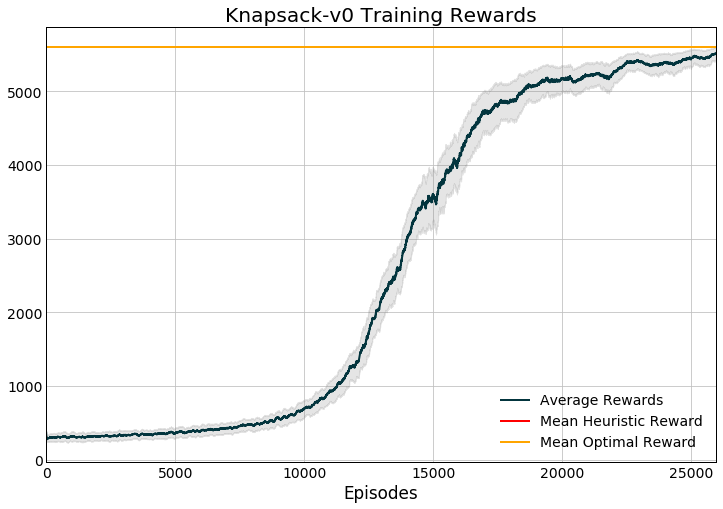

Optimization:	Rewards = 5600.0	Std = 0.0
Heuristic:	Rewards = 5600.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 5515.5	Std = 87.2	Ratio = 1.02


In [5]:
x_min = 0
x_max = kp0_plot_data.shape[0]
opt_mean0 = 5600
opt_var0 = 0
heur_mean0 = 5600
heur_var0 = 0

plt.figure(figsize=(12,8))
plt.plot(kp0_plot_data['mean_rewards'], label='Average Rewards')
plt.fill_between(np.arange(kp0_plot_data.shape[0]), 
    kp0_plot_data['fill_min'], kp0_plot_data['fill_max'],
                 color='gray', alpha=0.2) #, label='RL Variance')

plt.axhline(xmin=0, xmax=x_max, y=heur_mean0, color='r', label='Mean Heuristic Reward')

plt.axhline(xmin=0, xmax=x_max, y=opt_mean0, color='orange', label='Mean Optimal Reward')

plt.title('Knapsack-v0 Training Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.show()

print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
    opt_mean0, opt_var0))
print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    heur_mean0, heur_var0, opt_mean0 / heur_mean0))
rl_mean0 = kp0_plot_data.iloc[-1]['mean_rewards']
perf_ratio0 = opt_mean0 / rl_mean0
print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    rl_mean0, kp0_plot_data.iloc[-1]['std_rewards'], perf_ratio0))

# Knapsack-v1

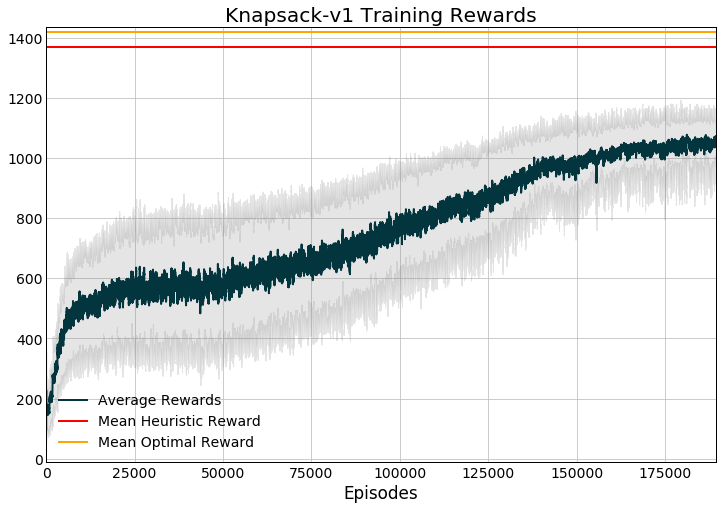

Optimization:	Rewards = 1419.0	Std = 0.0
Heuristic:	Rewards = 1368.0	Std = 0.0	Ratio = 1.04
RL:		Rewards = 1072.2	Std = 66.2	Ratio = 1.32


In [12]:
# kp1_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v1_5_entropy_coeff=0.001,kl_target=0.01,lambda=0.9,lr=0.0001_2020-05-29_10-17-44npw17d2w'
kp1_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v1_12_entropy_coeff=0.01,kl_target=0.01,lambda=0.9,lr=1e-05_2020-07-29_20-28-39oqnlkxeo'
kp1_plot_data, kp1_data = extract_plot_stats(kp1_path)

opt_mean1 = 1419
opt_var1 = 0
heur_mean1 = 1368
heur_var1 = 0

    
x_min = 0
x_max = kp1_plot_data.shape[0]


plt.figure(figsize=(12,8))
plt.plot(kp1_plot_data['mean_rewards'], label='Average Rewards')
plt.fill_between(np.arange(x_max), kp1_plot_data['fill_min'], kp1_plot_data['fill_max'],
                 color='gray', alpha=0.2) #, label='RL Variance')

plt.axhline(xmin=0, xmax=x_max, y=heur_mean1, color='r', label='Mean Heuristic Reward')
# plt.fill_between(np.arange(x_min, mean_vals.shape[0]), heur_mean-heur_var, 
#                  heur_mean+heur_var, color='r', alpha=0.2, label='Heuristic Variance')

plt.axhline(xmin=0, xmax=x_max, y=opt_mean1, color='orange', label='Mean Optimal Reward')
# plt.fill_between(np.arange(x_min, mean_vals.shape[0]), opt_mean-opt_var, 
#                  opt_mean+opt_var, color='orange', alpha=0.2, label='Optimization Variance')

plt.title('Knapsack-v1 Training Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.show()

print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
    opt_mean1, opt_var1))
print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    heur_mean1, heur_var1, opt_mean1 / heur_mean1))
rl_mean1 = kp1_plot_data.iloc[-1]['mean_rewards']
perf_ratio1 = opt_mean1 / rl_mean1
print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    rl_mean1, kp1_plot_data.iloc[-1]['std_rewards'], perf_ratio1))

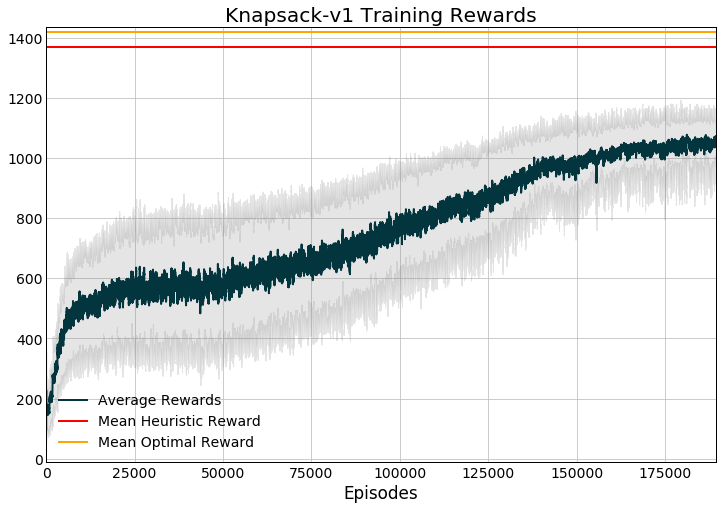

Optimization:	Rewards = 1419.0	Std = 0.0
Heuristic:	Rewards = 1368.0	Std = 0.0	Ratio = 1.04
RL:		Rewards = 1072.2	Std = 66.2	Ratio = 1.32


In [9]:
# kp1_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v1_5_entropy_coeff=0.001,kl_target=0.01,lambda=0.9,lr=0.0001_2020-05-29_10-17-44npw17d2w'
kp1_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v1_12_entropy_coeff=0.01,kl_target=0.01,lambda=0.9,lr=1e-05_2020-07-29_20-28-39oqnlkxeo'
kp1_plot_data, kp1_data = extract_plot_stats(kp1_path, window=100)

opt_mean1 = 1419
opt_var1 = 0
heur_mean1 = 1368
heur_var1 = 0

    
x_min = 0
x_max = kp1_plot_data.shape[0]


plt.figure(figsize=(12,8))
plt.plot(kp1_plot_data['mean_rewards'], label='Average Rewards')
plt.fill_between(np.arange(x_max), kp1_plot_data['fill_min'], kp1_plot_data['fill_max'],
                 color='gray', alpha=0.2) #, label='RL Variance')

plt.axhline(xmin=0, xmax=x_max, y=heur_mean1, color='r', label='Mean Heuristic Reward')
# plt.fill_between(np.arange(x_min, mean_vals.shape[0]), heur_mean-heur_var, 
#                  heur_mean+heur_var, color='r', alpha=0.2, label='Heuristic Variance')

plt.axhline(xmin=0, xmax=x_max, y=opt_mean1, color='orange', label='Mean Optimal Reward')
# plt.fill_between(np.arange(x_min, mean_vals.shape[0]), opt_mean-opt_var, 
#                  opt_mean+opt_var, color='orange', alpha=0.2, label='Optimization Variance')

plt.title('Knapsack-v1 Training Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.show()

print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
    opt_mean1, opt_var1))
print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    heur_mean1, heur_var1, opt_mean1 / heur_mean1))
rl_mean1 = kp1_plot_data.iloc[-1]['mean_rewards']
perf_ratio1 = opt_mean1 / rl_mean1
print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    rl_mean1, kp1_plot_data.iloc[-1]['std_rewards'], perf_ratio1))

# Knapsack-v2

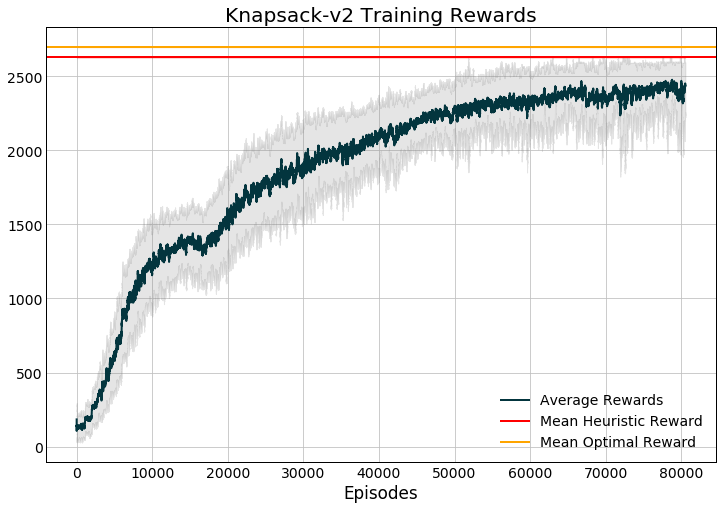

Optimization:	Rewards = 2696.0	Std = 0.0
Heuristic:	Rewards = 2627.0	Std = 0.0	Ratio = 1.03
RL:		Rewards = 2434.1	Std = 207.4	Ratio = 1.11


In [11]:
# kp2_path = '/home/christian/ray_results/A3C/A3C_Knapsack-v2_8_entropy_coeff=0.0001,lr=1e-06_2020-05-18_15-52-55u2a0r8jm'
kp2_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v2_5_entropy_coeff=0.001,kl_target=0.01,lr=1e-05_2020-07-30_10-05-27rvljkqky'
kp2_plot_data, kp2_data = extract_plot_stats(kp2_path, 100)

opt_mean2 = 2696
opt_var2 = 0
heur_mean2 = 2627
heur_var2 = 0

x_min = 0
x_max = kp2_plot_data.shape[0] / 10


plt.figure(figsize=(12,8))
plt.plot(kp2_plot_data['mean_rewards'], label='Average Rewards')
plt.fill_between(np.arange(kp2_plot_data.shape[0]), 
                 kp2_plot_data['fill_min'], kp2_plot_data['fill_max'],
                 color='gray', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=heur_mean2, color='r', label='Mean Heuristic Reward')
plt.fill_between(np.arange(kp2_plot_data.shape[0]), heur_mean2-heur_var2, 
                 heur_mean2+heur_var2, color='r', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=opt_mean2, color='orange', label='Mean Optimal Reward')
plt.fill_between(np.arange(kp2_plot_data.shape[0]), opt_mean2-opt_var2, 
                 opt_mean2+opt_var2, color='orange', alpha=0.2)

plt.title('Knapsack-v2 Training Rewards')
plt.legend()
plt.xlabel('Episodes')
# plt.xlim([x_min, x_max])
plt.show()

print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
    opt_mean2, opt_var2))
print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    heur_mean2, heur_var2, opt_mean2 / heur_mean2))
rl_mean2 = kp2_plot_data.iloc[-1]['mean_rewards']
perf_ratio2 = opt_mean2 / rl_mean2
print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    rl_mean2, kp2_plot_data.iloc[-1]['std_rewards'], perf_ratio2))

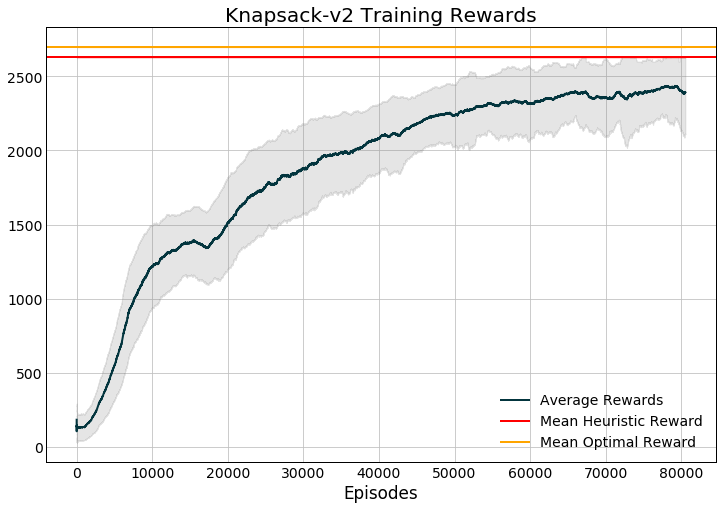

Optimization:	Rewards = 2696.0	Std = 0.0
Heuristic:	Rewards = 2627.0	Std = 0.0	Ratio = 1.03
RL:		Rewards = 2391.6	Std = 280.0	Ratio = 1.13


In [10]:
# kp2_path = '/home/christian/ray_results/A3C/A3C_Knapsack-v2_8_entropy_coeff=0.0001,lr=1e-06_2020-05-18_15-52-55u2a0r8jm'
kp2_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v2_5_entropy_coeff=0.001,kl_target=0.01,lr=1e-05_2020-07-30_10-05-27rvljkqky'
kp2_plot_data, kp2_data = extract_plot_stats(kp2_path, 1000)

opt_mean2 = 2696
opt_var2 = 0
heur_mean2 = 2627
heur_var2 = 0

x_min = 0
x_max = kp2_plot_data.shape[0] / 10


plt.figure(figsize=(12,8))
plt.plot(kp2_plot_data['mean_rewards'], label='Average Rewards')
plt.fill_between(np.arange(kp2_plot_data.shape[0]), 
                 kp2_plot_data['fill_min'], kp2_plot_data['fill_max'],
                 color='gray', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=heur_mean2, color='r', label='Mean Heuristic Reward')
plt.fill_between(np.arange(kp2_plot_data.shape[0]), heur_mean2-heur_var2, 
                 heur_mean2+heur_var2, color='r', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=opt_mean2, color='orange', label='Mean Optimal Reward')
plt.fill_between(np.arange(kp2_plot_data.shape[0]), opt_mean2-opt_var2, 
                 opt_mean2+opt_var2, color='orange', alpha=0.2)

plt.title('Knapsack-v2 Training Rewards')
plt.legend()
plt.xlabel('Episodes')
# plt.xlim([x_min, x_max])
plt.show()

print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
    opt_mean2, opt_var2))
print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    heur_mean2, heur_var2, opt_mean2 / heur_mean2))
rl_mean2 = kp2_plot_data.iloc[-1]['mean_rewards']
perf_ratio2 = opt_mean2 / rl_mean2
print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    rl_mean2, kp2_plot_data.iloc[-1]['std_rewards'], perf_ratio2))

# Knapsack-v3

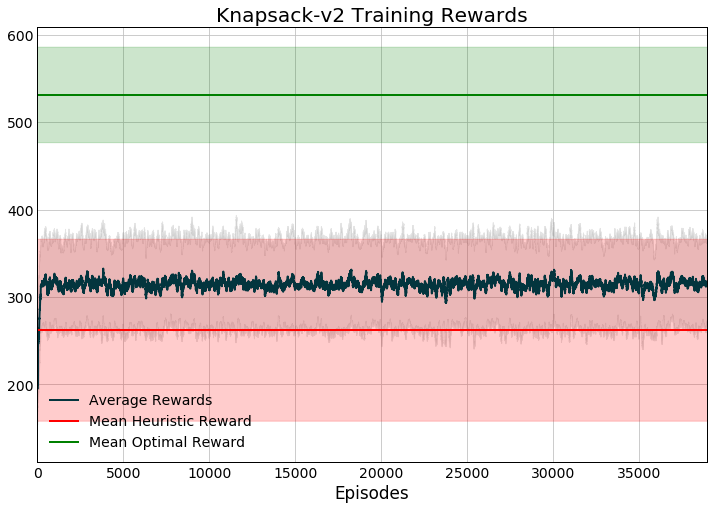

Optimization:	Rewards = 531.0	Std = 54.6
Heuristic:	Rewards = 262.0	Std = 104.0	Ratio = 2.03
RL:		Rewards = 315.4	Std = 46.6	Ratio = 1.68


In [16]:
kp3_path = '/home/christian/ray_results/A3C/A3C_Knapsack-v2_8_entropy_coeff=0.0001,lr=1e-06_2020-05-18_15-52-55u2a0r8jm'
# kp3_path = '/home/christian/ray_results/PPO/PPO_Knapsack-v3_5_entropy_coeff=0.001,kl_target=0.01,lr=1e-05_2020-08-01_22-22-2112qbjvbb'
kp3_plot_data, kp3_data = extract_plot_stats(kp3_path)

opt_mean3 = 531
opt_var3 = 54.6
heur_mean3 = 262
heur_var3 = 104

x_min = 0
x_max = kp3_plot_data.shape[0] / 2


plt.figure(figsize=(12,8))
plt.plot(kp3_plot_data['mean_rewards'], label='Average Rewards')
plt.fill_between(np.arange(kp3_plot_data.shape[0]), 
                 kp3_plot_data['fill_min'], kp3_plot_data['fill_max'],
                 color='gray', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=heur_mean3, color='r', label='Mean Heuristic Reward')
plt.fill_between(np.arange(kp3_plot_data.shape[0]), heur_mean3-heur_var3, 
                 heur_mean3+heur_var3, color='r', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=opt_mean3, color='green', label='Mean Optimal Reward')
plt.fill_between(np.arange(kp3_plot_data.shape[0]), opt_mean3-opt_var3, 
                 opt_mean3+opt_var3, color='green', alpha=0.2)

plt.title('Knapsack-v2 Training Rewards')
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.show()

print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
    opt_mean3, opt_var3))
print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    heur_mean3, heur_var3, opt_mean3 / heur_mean3))
rl_mean3 = kp3_plot_data.iloc[-1]['mean_rewards']
perf_ratio3 = opt_mean3 / rl_mean3
print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
    rl_mean3, kp3_plot_data.iloc[-1]['std_rewards'], perf_ratio3))

# Final Plot

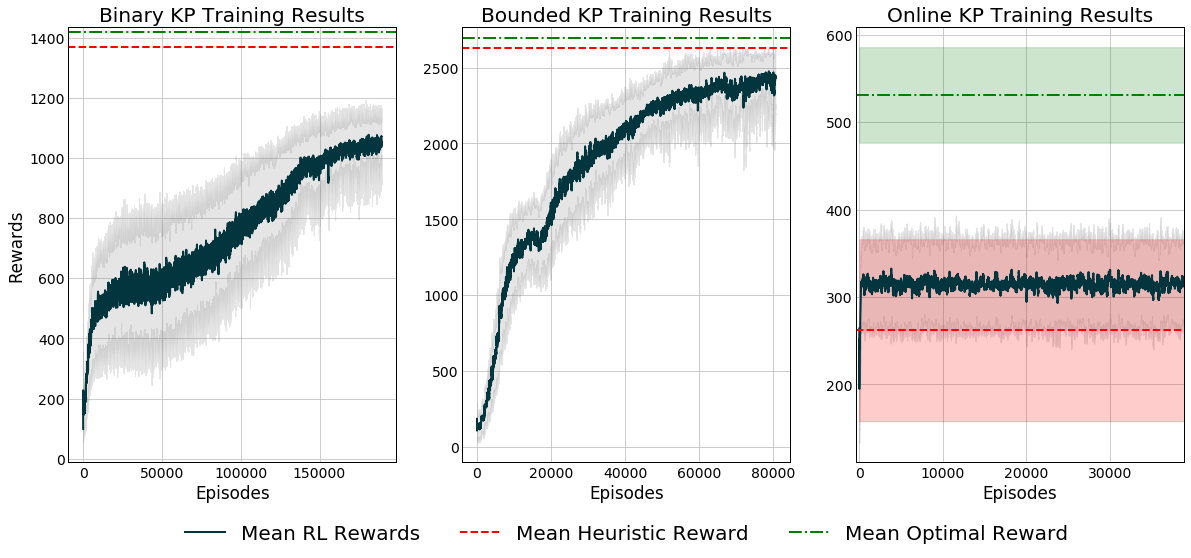

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20,8))
linestyles = ['--', '-.', ':', '-']

ax[0].plot(kp1_plot_data['mean_rewards'], label='Mean RL Rewards')
ax[0].fill_between(np.arange(kp1_plot_data.shape[0]), 
                   kp1_plot_data['fill_min'], 
                   kp1_plot_data['fill_max'],
                 color='gray', alpha=0.2)
ax[0].axhline(xmin=0, xmax=x_max, y=heur_mean1, 
              color='r', linestyle=linestyles[0],
              label='Mean Heuristic Reward')
ax[0].axhline(xmin=0, xmax=x_max, y=opt_mean1, 
              color='green', linestyle=linestyles[1],
              label='Mean Optimal Reward')
ax[0].set_ylabel('Rewards')
ax[0].set_xlabel('Episodes')
ax[0].set_title('Binary KP Training Results')

ax[1].plot(kp2_plot_data['mean_rewards'], label='Mean RL Rewards')
ax[1].fill_between(np.arange(kp2_plot_data.shape[0]), 
                   kp2_plot_data['fill_min'], 
                   kp2_plot_data['fill_max'],
                 color='gray', alpha=0.2)

ax[1].axhline(xmin=0, xmax=x_max, y=heur_mean2,
              color='r', linestyle=linestyles[0],
              label='Mean Heuristic Reward')
ax[1].axhline(xmin=0, xmax=x_max, y=opt_mean2,
              color='green', linestyle=linestyles[1],
              label='Mean Optimal Reward')
ax[1].set_xlabel('Episodes')
ax[1].set_title('Bounded KP Training Results')

ax[2].plot(kp3_plot_data['mean_rewards'], label='Mean RL Rewards')
ax[2].fill_between(np.arange(kp3_plot_data.shape[0]), 
                 kp3_plot_data['fill_min'], kp3_plot_data['fill_max'],
                 color='gray', alpha=0.2)

ax[2].axhline(xmin=0, xmax=x_max, y=heur_mean3, 
              color='r', linestyle=linestyles[0],
              label='Mean Heuristic Reward')
ax[2].fill_between(np.arange(kp3_plot_data.shape[0]), heur_mean3-heur_var3,
                 heur_mean3+heur_var3, color='r', alpha=0.2)

ax[2].axhline(xmin=0, xmax=x_max, y=opt_mean3,
              color='green', linestyle=linestyles[1],
              label='Mean Optimal Reward')
ax[2].fill_between(np.arange(kp3_plot_data.shape[0]), opt_mean3-opt_var3,
                 opt_mean3+opt_var3, color='green', alpha=0.2)
ax[2].set_xlim(-400, kp3_plot_data.shape[0]/2)

ax[2].set_xlabel('Episodes')
ax[2].set_title('Online KP Training Results')
ax[1].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.1), prop={'size': 20})

plt.show()

In [7]:
path = '/home/christian/ray_results/PPO/PPO_Knapsack-v0_70012da3_1_lr=0.001,vf_share_layers=True_2020-03-21_16-39-26_z6_97l8'
with open(f"{path}/params.json", "r") as read_file:
    config = json.load(read_file)
split_path = path.split("/")
algo = [j for i, j in enumerate(split_path) if split_path[i-1] == "ray_results"][0].lower()

In [4]:
def knapsack_model_check(version=0, test_runs=100):
    remove = string.punctuation
    remove = remove.replace('-', '')
    remove = remove.replace('.', '')
    
    N_SCENARIOS = test_runs
    df = pd.DataFrame()
    result_path = '../or_gym/benchmarks/results'
    env_name = f'Knapsack-v{version}'
    for f in os.listdir(result_path):
        if env_name in f:
            if len(df) < 1:
                df = pd.read_csv(os.path.join(result_path, f))
            else:
                df = pd.concat([df, pd.read_csv(os.path.join(result_path, f))])           

    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    top_results = df.loc[df['episode_reward_mean']>np.median(df['episode_reward_mean'])]
    # Ensure items weights and values are identical
    item_val = []
    top_perf_ratio, top_path = 1000, 'x'
    errors = {}
    error_count = 0
    for i, j in enumerate(top_results['logdir']):
        rew = top_results.iloc[i]['episode_reward_mean']
        try:
            kp_plot_data, kp_training = extract_plot_stats(j)
        except FileNotFoundError:
            print('\n{} not found (reward = {}).\n'.format(j, 
                rew))
            errors[error_count] = {
                'msg': 'Policy not found',
                'rew': rew,
                'path': j}
            error_count += 1
            continue

        try:
            trainer = load_policy(j)
        except Exception as e:
            print('\nPolicy file not found for {}\n'.format(j))
            errors[error_count] = {
                'msg': 'Policy not found',
                'rew': rew,
                'path': j}
            error_count += 1
            continue

        env = trainer.env_creator(trainer.config)

        if not hasattr(env, 'spec') or env.spec == None:
            spec = Spec(env_name)
            env.spec = spec
            
        item_val.append(np.hstack([env.item_values, env.item_weights]))

        # Run heuristics and opt
        if env_name == 'Knapsack-v0':
            heuristic_model = ukp_heuristic
            optimization_model = optimize_ukp
        elif env_name == 'Knapsack-v1':
            heuristic_model = bkp_heuristic
            optimization_model = optimize_bkp
        elif env_name == 'Knapsack-v2':
            heuristic_model = okp_heuristic
            optimization_model = optimize_okp
        try:
            heur_rewards = np.zeros(N_SCENARIOS)
            for n in range(N_SCENARIOS):
                _, r = heuristic_model(env)
                heur_rewards[n] = sum(r)
        except Exception as e:
            print("\nError in heuristic for {}".format(j))
            errors[error_count] = {
                'msg': 'Error in heuristic.',
                'rew': rew,
                'path': j}
            error_count += 1
            continue

        opt_rewards = np.zeros(N_SCENARIOS)
        try:
            for n in range(N_SCENARIOS):
                model, results = optimization_model(env)
                opt_rewards[n] = model.obj.expr()
        except Exception as e:
            print("Error in optimization for {}".format(j))
            errors[error_count] = {
                'msg': 'Error in optimization.',
                'rew': rew,
                'path': j}
            error_count += 1
            continue

        x_min = 0
        x_max = kp_plot_data.shape[0]
        opt_mean = opt_rewards.mean()
        opt_var = opt_rewards.std()
        heur_mean = heur_rewards.mean()
        heur_var = heur_rewards.std()

        print('\n' + j)
        print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
            opt_mean, opt_var))
        print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
            heur_mean, heur_var, opt_mean / heur_mean))
        rl_mean = kp_plot_data.iloc[-1]['mean_rewards']
        perf_ratio = opt_mean / rl_mean
        print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
            rl_mean, kp_plot_data.iloc[-1]['std_rewards'], perf_ratio))
        
        if perf_ratio < top_perf_ratio:
            top_perf_ratio = perf_ratio
            top_path = copy.copy(j)

        plt.figure(figsize=(12,8))
        plt.plot(kp_plot_data['mean_rewards'], label='Average Rewards')
        plt.fill_between(np.arange(kp_plot_data.shape[0]), 
            kp_plot_data['fill_min'], kp_plot_data['fill_max'],
                         color='gray', alpha=0.2) #, label='RL Variance')

        plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color='r', label='Mean Heuristic Reward')
        plt.fill_between(np.arange(x_min, kp_plot_data.shape[0]), heur_mean-heur_var, 
                         heur_mean+heur_var, color='r', alpha=0.2)#, label='Heuristic Variance')

        plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color='orange', label='Mean Optimal Reward')
        # plt.fill_between(np.arange(x_min, mean_vals.shape[0]), opt_mean-opt_var, 
        #                  opt_mean+opt_var, color='orange', alpha=0.2, label='Optimization Variance')

        plt.title(f'Knapsack-v{version} Training Rewards')
        plt.legend()
        plt.xlabel('Episodes')
        plt.xlim([x_min, x_max])
        plt.show()
    
    return df, top_path, errors, item_val

In [5]:
df, path, errors, items = knapsack_model_check(2)

2020-05-28 11:19:38,810	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-05-28 11:19:38,820	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-05-28 11:20:31,702	INFO trainable.py:102 -- _setup took 52.885 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-05-28 11:20:31,703	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-28 11:20:31,825	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/A3C/A3C_Knapsack-v2_0_entropy_coeff=0.01,lr=0.0001_2020-05-18_13-47-22s964f8vj/checkpoint_500/checkpoint-500
2020-05-28 11:20:31,831	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 2487.5626249313354, '_episodes_total': 69155}



Error in heuristic for /home/christian/ray_results/A3C/A3C_Knapsack-v2_0_entropy_coeff=0.01,lr=0.0001_2020-05-18_13-47-22s964f8vj


2020-05-28 11:20:54,549	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-28 11:20:54,682	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/A3C/A3C_Knapsack-v2_2_entropy_coeff=0.0001,lr=0.0001_2020-05-18_13-47-229zusld22/checkpoint_500/checkpoint-500
2020-05-28 11:20:54,686	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 4995.149082183838, '_episodes_total': 73340}



Error in heuristic for /home/christian/ray_results/A3C/A3C_Knapsack-v2_2_entropy_coeff=0.0001,lr=0.0001_2020-05-18_13-47-229zusld22


2020-05-28 11:21:17,383	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-28 11:21:17,537	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/A3C/A3C_Knapsack-v2_3_entropy_coeff=0.01,lr=1e-05_2020-05-18_14-29-09dnnsr4ht/checkpoint_500/checkpoint-500
2020-05-28 11:21:17,544	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 2494.6254472732544, '_episodes_total': 72647}



Error in heuristic for /home/christian/ray_results/A3C/A3C_Knapsack-v2_3_entropy_coeff=0.01,lr=1e-05_2020-05-18_14-29-09dnnsr4ht


2020-05-28 11:21:42,021	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-28 11:21:42,134	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/A3C/A3C_Knapsack-v2_4_entropy_coeff=0.001,lr=1e-05_2020-05-18_14-29-09imz4vua1/checkpoint_500/checkpoint-500
2020-05-28 11:21:42,139	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 4997.503765583038, '_episodes_total': 80179}



Error in heuristic for /home/christian/ray_results/A3C/A3C_Knapsack-v2_4_entropy_coeff=0.001,lr=1e-05_2020-05-18_14-29-09imz4vua1


KeyboardInterrupt: 

In [61]:
env = or_gym.make('Knapsack-v2')

rewards = np.zeros(100)
for i in range(100):
    actions, items, r = okp_heuristic(env)
    rewards[i] = sum(r)
    
print(rewards.mean(), rewards.std())

261.65 107.84687060828422


In [45]:
rewards = np.zeros(100)
for i in range(100):
    scenario = np.random.choice(env.item_numbers, p=env.item_probs, size=env.step_limit)
    model, results = optimize_okp(env, scenario)
    rewards[i] = model.obj.expr()

print(rewards.mean(), rewards.std())

530.94 54.60802505126879


In [53]:
513/1.7

301.7647058823529

In [52]:
531/262

2.0267175572519083

In [28]:
env.reset()
scenario = None
done = False
actions, items_taken, items_offered, rewards = [], [], [], []
r = bool(np.random.choice([0, 1]))
count, rejection_weight = 0, 0
while not done:
    if scenario is not None:
        item = scenario[count]
    else:
        item = copy.copy(env.current_item)
    action = 0
    if r:
        # Greedy
        if env.item_weights[item] <= (env.max_weight - env.current_weight):
            action = 1
    else:
        rejection_weight += env.item_weights[item]
        if rejection_weight > env.max_weight:
            action = 1
    state, reward, done, _ = env.step(action)
    actions.append(action)
    rewards.append(reward)
    items_offered.append(item)
    count += 1

In [29]:
sum(rewards), r

(0, False)

In [30]:
rejection_weight

150

In [32]:
count

50

2020-05-27 12:45:35,482	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:45:35,594	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_0_entropy_coeff=0.001,lr=0.0001_2020-05-17_21-43-42mcapx7qn/checkpoint_500/checkpoint-500
2020-05-27 12:45:35,595	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 4315.27676987648, '_episodes_total': 37831}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_0_entropy_coeff=0.001,lr=0.0001_2020-05-17_21-43-42mcapx7qn
Optimization:	Rewards = 2230.0	Std = 0.0
Heuristic:	Rewards = 2230.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1398.5	Std = 190.9	Ratio = 1.59


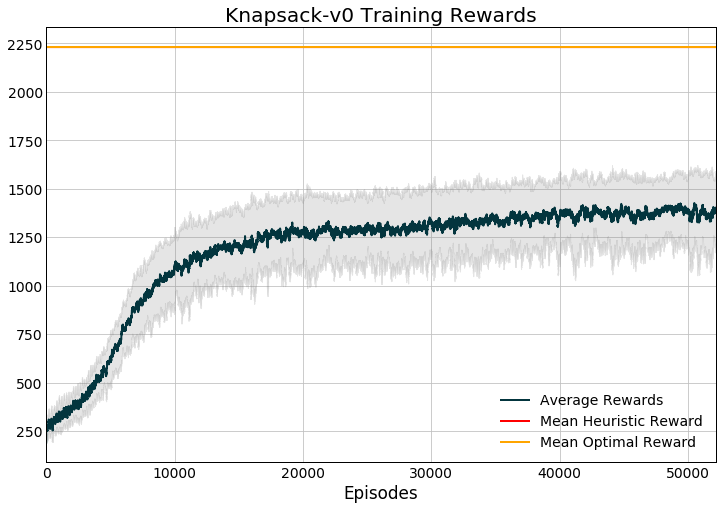

2020-05-27 12:46:00,162	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:46:00,254	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_1_entropy_coeff=0.0001,lr=0.0001_2020-05-17_21-43-42ggkerlg4/checkpoint_500/checkpoint-500
2020-05-27 12:46:00,255	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 4319.205410242081, '_episodes_total': 36700}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_1_entropy_coeff=0.0001,lr=0.0001_2020-05-17_21-43-42ggkerlg4
Optimization:	Rewards = 2203.0	Std = 0.0
Heuristic:	Rewards = 2200.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1459.5	Std = 385.0	Ratio = 1.51


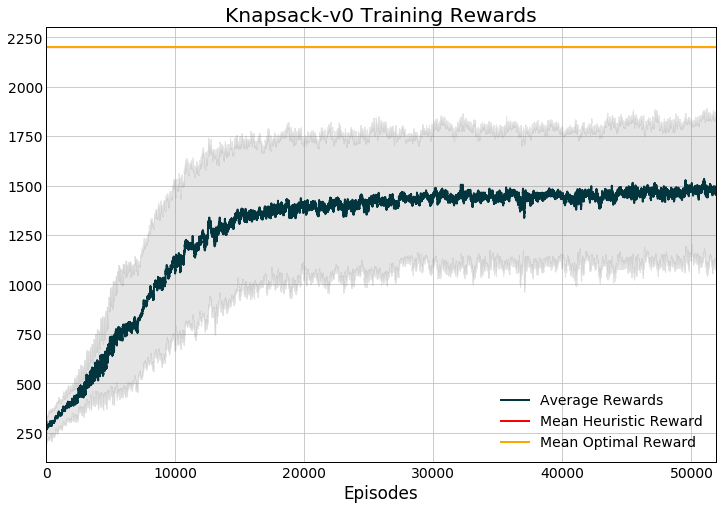

2020-05-27 12:46:23,427	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:46:23,544	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_2_entropy_coeff=0.001,lr=1e-05_2020-05-17_21-43-42a_gvea3b/checkpoint_500/checkpoint-500
2020-05-27 12:46:23,546	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 8620.665562868118, '_episodes_total': 37498}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_2_entropy_coeff=0.001,lr=1e-05_2020-05-17_21-43-42a_gvea3b
Optimization:	Rewards = 2298.0	Std = 0.0
Heuristic:	Rewards = 2298.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1376.7	Std = 242.6	Ratio = 1.67


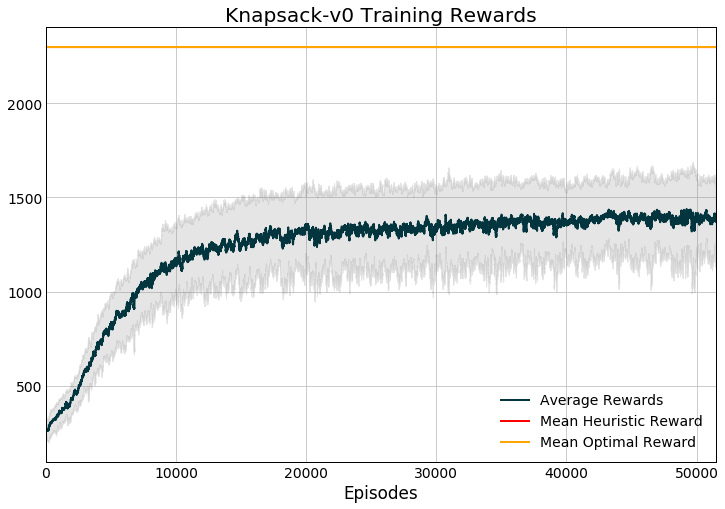

2020-05-27 12:46:46,520	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:46:46,619	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_3_entropy_coeff=0.0001,lr=1e-05_2020-05-17_22-55-58o_y9j2wi/checkpoint_500/checkpoint-500
2020-05-27 12:46:46,621	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 8584.524733304977, '_episodes_total': 32935}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_3_entropy_coeff=0.0001,lr=1e-05_2020-05-17_22-55-58o_y9j2wi
Optimization:	Rewards = 2173.0	Std = 0.0
Heuristic:	Rewards = 2173.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1552.9	Std = 305.2	Ratio = 1.40


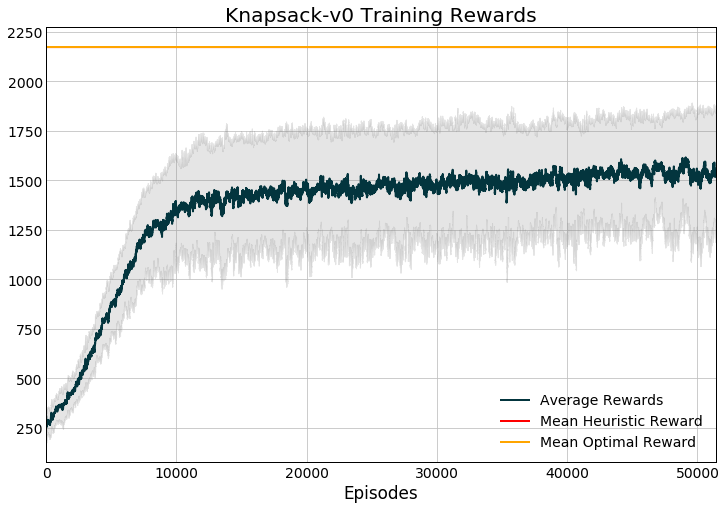

2020-05-27 12:47:09,481	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:47:09,576	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_4_entropy_coeff=0.001,lr=1e-06_2020-05-17_22-55-58r4ty1ldm/checkpoint_500/checkpoint-500
2020-05-27 12:47:09,577	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 4293.307883024216, '_episodes_total': 38130}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_4_entropy_coeff=0.001,lr=1e-06_2020-05-17_22-55-58r4ty1ldm
Optimization:	Rewards = 2402.0	Std = 0.0
Heuristic:	Rewards = 2402.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1294.9	Std = 255.5	Ratio = 1.85


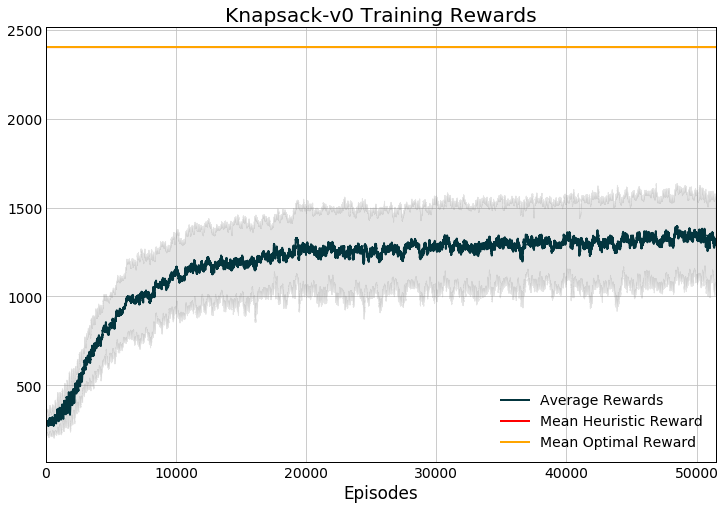

2020-05-27 12:47:30,025	WARNING util.py:45 -- Install gputil for GPU system monitoring.



Policy file not found for /home/christian/ray_results/PPO/PPO_Knapsack-v1_b81c8ed2_0_entropy_coeff=0.01,lr=0.0001,vf_share_layers=False_2020-04-14_21-49-26lu88frzh



2020-05-27 12:47:37,722	WARNING util.py:45 -- Install gputil for GPU system monitoring.



Policy file not found for /home/christian/ray_results/PPO/PPO_Knapsack-v1_b81c8ed3_1_entropy_coeff=0.001,lr=0.0001,vf_share_layers=False_2020-04-14_21-49-26w7ngczmw



2020-05-27 12:47:44,895	WARNING util.py:45 -- Install gputil for GPU system monitoring.



Policy file not found for /home/christian/ray_results/PPO/PPO_Knapsack-v1_b81c8ed5_3_entropy_coeff=0.001,lr=1e-05,vf_share_layers=False_2020-04-14_22-29-31oi9coc9n



2020-05-27 12:47:52,046	WARNING util.py:45 -- Install gputil for GPU system monitoring.



Policy file not found for /home/christian/ray_results/PPO/PPO_Knapsack-v1_b81c8ed7_5_entropy_coeff=0.001,lr=1e-06,vf_share_layers=False_2020-04-14_23-09-44_d8mcg8h



2020-05-27 12:48:01,894	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:48:01,992	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_0_entropy_coeff=0.01,lr=0.0001_2020-05-22_19-25-17jm8g_q8n/checkpoint_500/checkpoint-500
2020-05-27 12:48:01,993	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 5278.2059674263, '_episodes_total': 39795}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_0_entropy_coeff=0.01,lr=0.0001_2020-05-22_19-25-17jm8g_q8n
Optimization:	Rewards = 1904.0	Std = 0.0
Heuristic:	Rewards = 1904.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1236.8	Std = 219.8	Ratio = 1.54


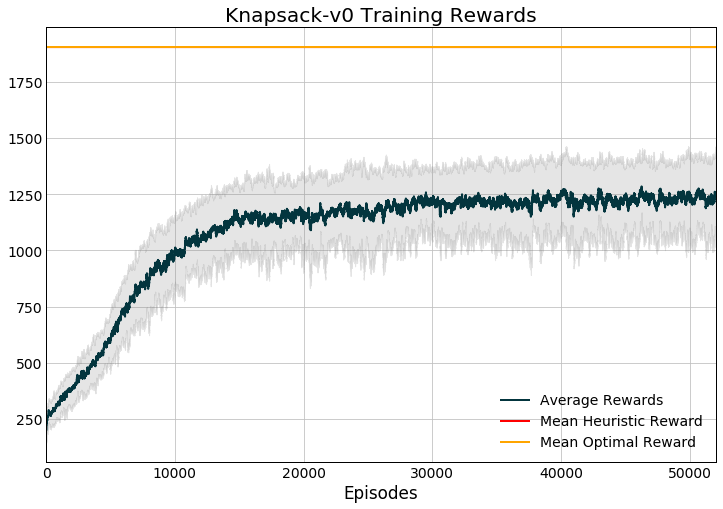

2020-05-27 12:48:25,614	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:48:25,718	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_1_entropy_coeff=0.001,lr=0.0001_2020-05-22_19-25-17dkar28wz/checkpoint_500/checkpoint-500
2020-05-27 12:48:25,719	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 5274.304768323898, '_episodes_total': 36509}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_1_entropy_coeff=0.001,lr=0.0001_2020-05-22_19-25-17dkar28wz
Optimization:	Rewards = 2134.0	Std = 0.0
Heuristic:	Rewards = 2134.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1401.9	Std = 295.4	Ratio = 1.52


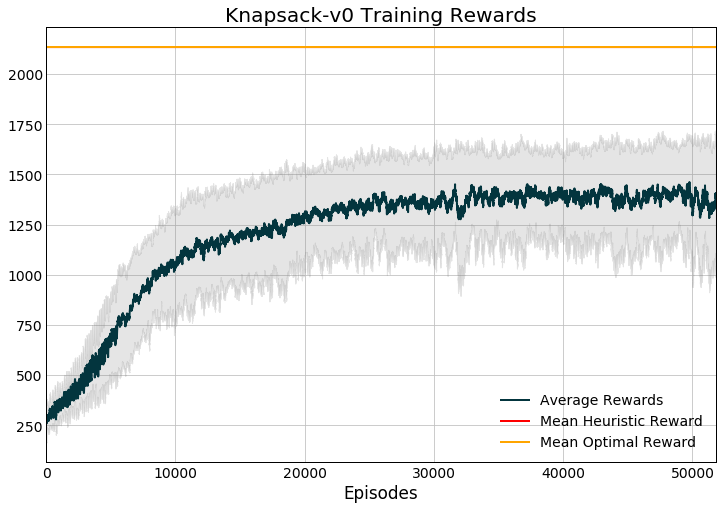

2020-05-27 12:48:50,298	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:48:50,414	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_2_entropy_coeff=0.0001,lr=0.0001_2020-05-22_19-25-175hnsucwu/checkpoint_500/checkpoint-500
2020-05-27 12:48:50,415	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 11235.260339021683, '_episodes_total': 35699}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_2_entropy_coeff=0.0001,lr=0.0001_2020-05-22_19-25-175hnsucwu
Optimization:	Rewards = 2053.0	Std = 0.0
Heuristic:	Rewards = 2053.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1438.2	Std = 289.8	Ratio = 1.43


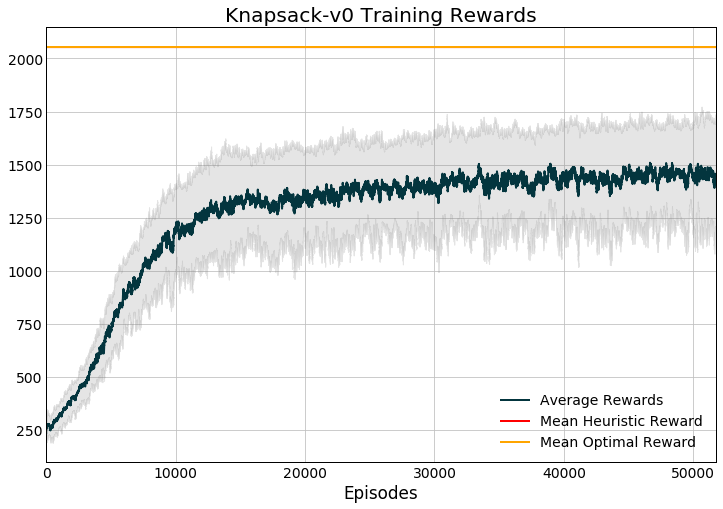

2020-05-27 12:49:14,688	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:49:14,799	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_3_entropy_coeff=0.01,lr=1e-05_2020-05-22_20-53-34z_qeujnk/checkpoint_500/checkpoint-500
2020-05-27 12:49:14,800	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 5935.85967373848, '_episodes_total': 35155}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_3_entropy_coeff=0.01,lr=1e-05_2020-05-22_20-53-34z_qeujnk
Optimization:	Rewards = 2237.0	Std = 0.0
Heuristic:	Rewards = 2237.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1343.0	Std = 261.2	Ratio = 1.67


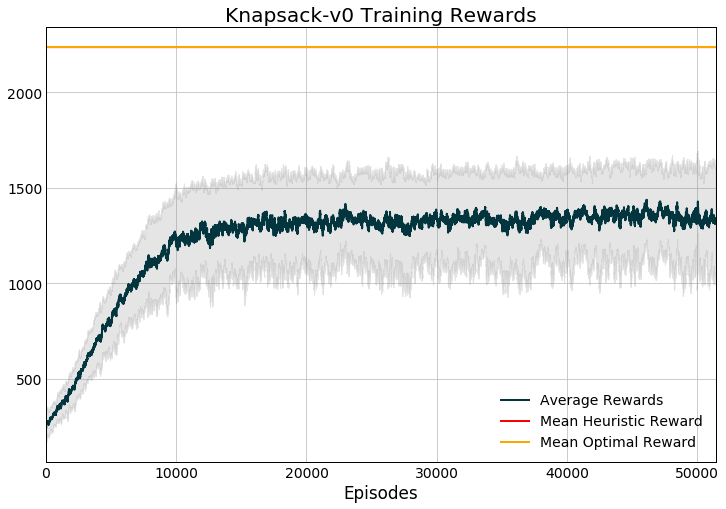

2020-05-27 12:49:38,449	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:49:38,548	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_4_entropy_coeff=0.001,lr=1e-05_2020-05-22_20-53-34xz5a0vxo/checkpoint_500/checkpoint-500
2020-05-27 12:49:38,549	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 12169.458728551865, '_episodes_total': 39068}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_4_entropy_coeff=0.001,lr=1e-05_2020-05-22_20-53-34xz5a0vxo
Optimization:	Rewards = 1968.0	Std = 0.0
Heuristic:	Rewards = 1968.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1220.4	Std = 250.1	Ratio = 1.61


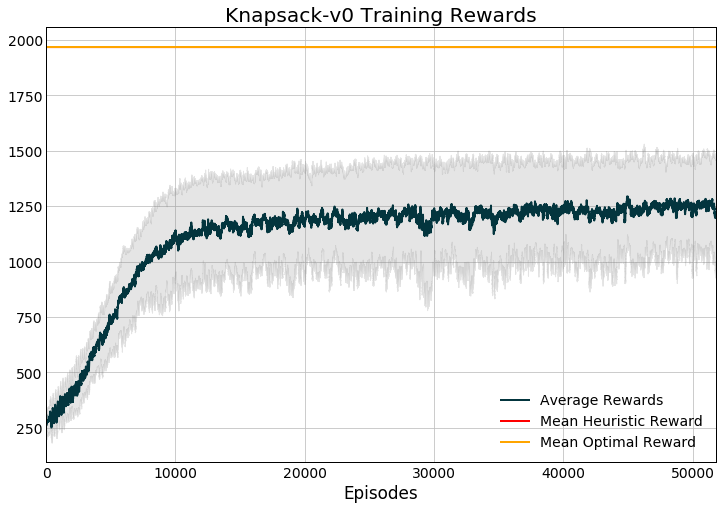

2020-05-27 12:50:02,595	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-27 12:50:02,689	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_Knapsack-v1_5_entropy_coeff=0.0001,lr=1e-05_2020-05-22_22-33-00o721cig0/checkpoint_500/checkpoint-500
2020-05-27 12:50:02,690	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 6178.554718732834, '_episodes_total': 36846}



/home/christian/ray_results/PPO/PPO_Knapsack-v1_5_entropy_coeff=0.0001,lr=1e-05_2020-05-22_22-33-00o721cig0
Optimization:	Rewards = 1896.0	Std = 0.0
Heuristic:	Rewards = 1892.0	Std = 0.0	Ratio = 1.00
RL:		Rewards = 1460.1	Std = 312.9	Ratio = 1.30


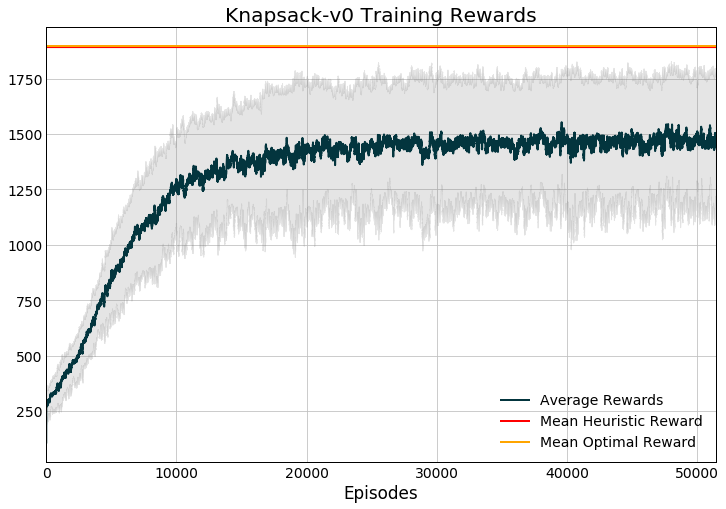

2020-05-27 12:50:27,492	WARNING util.py:45 -- Install gputil for GPU system monitoring.


ValueError: Cannot feed value of shape (603, 128) for Tensor 'default_policy/Placeholder_default_policy/fc_1/kernel:0', which has shape '(1003, 128)'

In [52]:
remove = string.punctuation
remove = remove.replace('-', '')
remove = remove.replace('.', '')
N_SCENARIOS = 100
df = pd.DataFrame()
result_path = '../or_gym/benchmarks/results'
env_name = 'Knapsack-v1'
for f in os.listdir(result_path):
    if env_name in f:
        if len(df) < 1:
            df = pd.read_csv(os.path.join(result_path, f))
        else:
            df = pd.concat([df, pd.read_csv(os.path.join(result_path, f))])           
            
# df.drop('Unnamed: 0', axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

top_results = df.loc[df['episode_reward_mean']>np.median(df['episode_reward_mean'])]
for i, j in enumerate(top_results['logdir']):
    try:
        kp0_plot_data, kp_training = extract_plot_stats(j)
    except FileNotFoundError:
        print('\n{} not found (reward = {}).\n'.format(j, 
            top_results.iloc[i]['episode_reward_mean']))
        continue
        
    try:
        trainer = load_policy(j)
    except FileNotFoundError:
        print('\nPolicy file not found for {}\n'.format(j))
        continue
        
    env = trainer.env_creator(trainer.config)
        
    if not hasattr(env, 'spec') or env.spec == None:
        spec = Spec(env_name)
        env.spec = spec
        
    # Run heuristics and opt
    try:
        bkp_heur_rewards = np.zeros(N_SCENARIOS)
        for n in range(N_SCENARIOS):
            _, r = bkp_heuristic(env)
            bkp_heur_rewards[n] = sum(r)

        bkp_opt_rewards = np.zeros(N_SCENARIOS)
        for n in range(N_SCENARIOS):
            model, results = optimize_bkp(env)
            bkp_opt_rewards[n] = model.obj.expr()
    except Error as e:
        pass
        
    x_min = 0
    x_max = kp0_plot_data.shape[0]
    opt_mean = bkp_opt_rewards.mean()
    opt_var = bkp_opt_rewards.std()
    heur_mean = bkp_heur_rewards.mean()
    heur_var = bkp_heur_rewards.std()
    
    print('\n' + j)
    print("Optimization:\tRewards = {:.1f}\tStd = {:.1f}".format(
        opt_mean, opt_var))
    print("Heuristic:\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
        heur_mean, heur_var, opt_mean / heur_mean))
    mean_val = kp0_plot_data.iloc[-1]['mean_rewards']
    print("RL:\t\tRewards = {:.1f}\tStd = {:.1f}\tRatio = {:.2f}".format(
        mean_val, kp0_plot_data.iloc[-1]['std_rewards'], opt_mean / mean_val))

    plt.figure(figsize=(12,8))
    plt.plot(kp0_plot_data['mean_rewards'], label='Average Rewards')
    plt.fill_between(np.arange(kp0_plot_data.shape[0]), 
        kp0_plot_data['fill_min'], kp0_plot_data['fill_max'],
                     color='gray', alpha=0.2) #, label='RL Variance')

    plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color='r', label='Mean Heuristic Reward')
    plt.fill_between(np.arange(x_min, kp0_plot_data.shape[0]), heur_mean-heur_var, 
                     heur_mean+heur_var, color='r', alpha=0.2)#, label='Heuristic Variance')

    plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color='orange', label='Mean Optimal Reward')
    # plt.fill_between(np.arange(x_min, mean_vals.shape[0]), opt_mean-opt_var, 
    #                  opt_mean+opt_var, color='orange', alpha=0.2, label='Optimization Variance')

    plt.title('Knapsack-v0 Training Rewards')
    plt.legend()
    plt.xlabel('Episodes')
    plt.xlim([x_min, x_max])
    plt.show()

In [55]:
np.hstack([env.item_values, env.item_weights]).shape

(400,)

In [92]:
trainer.config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'sample_batch_size': 200,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 4000,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'elu',
  'fcnet_hiddens': [128, 128, 128],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': False,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_preprocessor': None,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {}},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {'mask': True},
 'env': 'KnapsackEnv',
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 1e-07,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_star